# NAIVE BAYES FROM SCRATCH WITH TFIDF BASED FEATURE SELECTION

### IMPORTING REQUIRED MODULES

In [40]:
import re
from nltk import word_tokenize
import glob  
from nltk.corpus import stopwords
import time
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import os
import sys 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import math
import json
import numpy as np
import pandas as  pd
from prettytable import PrettyTable
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from statistics import mode
from sklearn.metrics import confusion_matrix
import itertools
import copy
from IPython.display import display

### DATA PRE-PROCESSING FUNCTION

In [41]:
def preprocess(data):
    stopword=""
    cleantext = " "
    stopword = set(stopwords.words('english'))
    for i in word_tokenize(data):
        i=i.lower()
        if i not in stopword and len(i)>2 and not(any(l.isdigit() for l in i)):
            pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
            pattern2 = '[\n\n]+'
            pattern3 = '[\ \ ]+'
            wout_sc = re.sub(pattern1,'',i) #removing special characters
            wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
            wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
            cleaned_text = wout_mspaces.strip()
            cleaned_text=lemmatizer.lemmatize(cleaned_text)
            cleantext = cleantext+cleaned_text+" "
    return cleantext.strip()

### READING THE NAMES OF ALL THE FILES ATTACHED WITH CORRESPONDING CLASS NAME

In [42]:
def read_names(path):
    i=0
    df = pd.DataFrame(columns=['Doc_Name'])
    folders = glob.glob(path)
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                head1,tail1 = os.path.split(file)
                df.loc[i] = tail+"_"+tail1
                i=i+1
    return df

### TRAIN-TEST SPLIT (DECISION MAKING FOR A DOC TO BE TRAIN OR TEST)

In [43]:
def split(ratio,data_frame):
    data_frame_temp = data_frame.copy()
    train_files,test_files = train_test_split(data_frame_temp,train_size=ratio,random_state=0)
    return train_files,test_files

### READING THE DATA, BUILDING TFs and DFs & BUILDING TF-IDFs FOR TRAINING SET 
### (WE CALCULATE TF IN THE CLASS AND DF ACROSS THE CLASSES)
### CORPUS CONSIDERED :: "20 news groups"
### FOLDERS CONSIDERED:
### 1. comp.graphics
### 2. sci.med
### 3.talk.politics.misc
### 4.rec.sport.hockey
### 5.sci.space

In [44]:
def readfiles(path,ratio,test_files):
    folders = glob.glob(path)
    preproc_data_dict={} ## key : file-name, value: pre-processed data
    tfs_class_wise={}
    df_dict={}
    files_read=0
    train_files_class_wise={}
    test_preproc_dict={}
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                flag=0
                head1,tail1 = os.path.split(file)
                with open(file) as newlinetest:   ## identifying the first new line in the data.. to remove meta-data
                    indi = newlinetest.readlines()
                for newline in range(len(indi)):
                    if(indi[newline]!="\n"):
                        continue
                    break
                filedata=[]
                try:
                    with open(file,"r") as data:  ## READING THE DATA ignoring the meta-data
                        filedata.append(data.readlines()[newline+1:])
                        for l in range(len(filedata)):
                            inter_data = ' '.join(filedata[l])
                    preproc_data = preprocess(inter_data)
                    if(tail+"_"+tail1 not in list(test_files['Doc_Name'])): ## reading only the training data
                        files_read+=1
                        if tail not in train_files_class_wise:
                            train_files_class_wise[tail]=1
                        else:
                            train_files_class_wise[tail]+=1
                        if tail not in preproc_data_dict: ## merging the data of all documents belonging to a single class..
                            preproc_data_dict[tail] = preproc_data
                        else:
                            preproc_data_dict[tail] = preproc_data_dict[tail]+" "+preproc_data
                    else:
                        test_preproc_dict[tail+"_"+tail1] = preproc_data
                    
                except e:
                    print("EXCEPTION OCCURED..")                  
    print("TOTAL TRAINING FILES READ::",files_read)
    data=" "
    print("\n====> GENERATING/LOADING IDFs...\n")
    #for d in preproc_data_dict:
    #    data = data+" "+preproc_data_dict[d] ## computing inverse document frequencies...
    #unique_words = list(set(data.split()))
    #for w in tqdm(unique_words,leave=True,position=0):
    #    df_dict[w]=0
    #    for key in preproc_data_dict:
    #        if w in preproc_data_dict[key].split():
    #            df_dict[w]+=1
    #    df_dict[w] = math.log10(len(preproc_data_dict.keys())/df_dict[w]) ##preproc_data_dict.keys() ==> total number of classes
    if(ratio==0.50):
        pickle_in = open("df_nb_tfidf_5050","rb")
        df_dict = pickle.load(pickle_in)
        print("IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("df_nb_tfidf_7030","rb")
        df_dict = pickle.load(pickle_in)
        print("IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("df_nb_tfidf_8020","rb")
        df_dict = pickle.load(pickle_in)
        print("IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
        
    print("LENGTH OF VOCABULARY::",len(df_dict))
    print("\n====> GENERATING TFs...\n")
    for d in tqdm(preproc_data_dict,leave=True,position=0): ## computing term-frequencies....
        tf_dict={}
        for w in preproc_data_dict[d].split():
            if w not in tf_dict:
                tf_dict[w]=1
            else:
                tf_dict[w]+=1
        tfs_class_wise[d] = tf_dict
    tfidfs_class_wise = copy.deepcopy(tfs_class_wise)
    print("\n====> GENERATING TF-IDFS...\n")
    for i in tqdm(tfidfs_class_wise,leave=True,position=0):
        for j in tfidfs_class_wise[i]:
            tfidfs_class_wise[i][j] = (1+math.log10(tfidfs_class_wise[i][j]))*df_dict[j]
    return tfidfs_class_wise,tfs_class_wise,train_files_class_wise,test_preproc_dict,preproc_data_dict,len(df_dict),df_dict

### PICKLE THE DOCUMENT FREQUENCIES

In [45]:
#pickle_out = open("df_nb_tfidf_5050","wb")
#pickle.dump(df_dict, pickle_out)
print("PICKLED IDFs corresponding to 50-50 split")

PICKLED IDFs corresponding to 50-50 split


In [46]:
#pickle_out = open("df_nb_tfidf_7030","wb")
#pickle.dump(df_dict, pickle_out)
print("PICKLED IDFs corresponding to 70-30 split")

PICKLED IDFs corresponding to 70-30 split


In [47]:
#pickle_out = open("df_nb_tfidf_8020","wb")
#pickle.dump(df_dict, pickle_out)
print("PICKLED IDFs corresponding to 80-20 split")

PICKLED IDFs corresponding to 80-20 split


## CODE EXECUTION STARTS HERE

In [48]:
path = "C:\\Users\\Sai Kumar\\Desktop\\SEM-2\\IR\\20NEWS\\20_newsgroups\\*"
train_size=[]
features=[]
perf=[]
dec = "y"
while(dec == "y" or dec =="Y"):
    print("\n====> READING NAMES OF THE FILES...\n")
    files_df = read_names(path)
    ratio = float(input("ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::"))
    train_files,test_files = split(ratio,files_df)
    print("COUNT OF TRAINING FILES CONSIDERED::",len(train_files))
    print("COUNT OF TEST FILES CONSIDERED::",len(test_files))
    print("\n====> READING DOCUMENTS...\n")
    tfidfs_class_wise,tfs_class_wise,train_files_class_wise,test_preproc_dict,preproc_data_dict,voc_len,df_dict = readfiles(path,ratio,test_files)
    feat_selection = float(input("ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::"))
    #print("before feat selec::",len(tfidfs_class_wise['comp.graphics']))
    for i in tfidfs_class_wise:
        tfidfs_class_wise[i] = dict(sorted(tfidfs_class_wise[i].items(),key=operator.itemgetter(1),reverse=True))
        tfidfs_class_wise[i] = dict(itertools.islice(tfidfs_class_wise[i].items(),round(len(tfidfs_class_wise[i])*feat_selection)))
    #print("after feat selec::",len(tfidfs_class_wise['comp.graphics']))
    test_files = list(test_preproc_dict.keys()) ## contains names of test files...
    classes = list(train_files_class_wise.keys()) ## contains names of classes...
    predictions=[]
    ground_truth=[]
    print("\n GENERATING PREDICTIONS...\n")
    for i in tqdm(test_files,leave=True,position=0):  ## sci.med_1234 etc..
        ground_truth.append(i.split("_")[0])
        pred_temp={}
        for j in classes: ## comp.graphics etc..
            prob=math.log10(train_files_class_wise[j]/sum(train_files_class_wise.values()))
            for k in test_preproc_dict[i].split():
                if k in tfidfs_class_wise[j]:## if the "term" is in top-k features then computing its log-probs..otherwise
                    
                    prob = prob+math.log10((tfs_class_wise[j][k]+1)/(sum(tfs_class_wise[j].values())+voc_len))
                else:                        ##doing add-one smoothing...
                    prob = prob+math.log10(1/(sum(tfs_class_wise[j].values())+voc_len))
            pred_temp[j]=prob
        pred_temp = dict(sorted(pred_temp.items(),key=operator.itemgetter(1),reverse=True))
        ##sorting in desc-order based on probs
        ##print(pred_temp)
        predictions.append(list(pred_temp.keys())[0]) ## appending 1st key value as prediction
    acc=0
    for i in range(len(test_files)):
        if(predictions[i]==ground_truth[i]):
            acc+=1
    acc = acc/len(test_files)
    print("ACCURACY ON TEST DATA:: ",acc*100,"%")
    train_size.append(ratio)
    features.append(feat_selection)
    perf.append(acc)
    print("CONFUSION MATRIX ON TEST DATA:: ")
    #ref:https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    dec = input("DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::")


====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.82it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 34414

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.79it/s]



====> GENERATING TF-IDFS...



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.46it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.10

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:24<00:00,  8.34it/s]


ACCURACY ON TEST DATA::  72.24000000000001 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,423,84,2,2,0
rec.sport.hockey,0,499,0,1,0
sci.med,11,114,367,3,0
sci.space,19,107,2,359,0
talk.politics.misc,9,339,0,1,158


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.86it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 34414

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.55it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 98.30it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.20

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:12<00:00, 11.40it/s]


ACCURACY ON TEST DATA::  79.60000000000001 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,437,68,2,4,0
rec.sport.hockey,0,499,0,1,0
sci.med,6,42,444,3,0
sci.space,16,61,2,408,0
talk.politics.misc,9,278,13,5,202


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.94s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 34414

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.43it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.24it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.40

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:52<00:00,  7.09it/s]


ACCURACY ON TEST DATA::  80.92 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,464,43,0,4,0
rec.sport.hockey,0,499,0,1,0
sci.med,14,40,439,2,0
sci.space,29,48,2,408,0
talk.politics.misc,16,258,14,6,213


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 34414

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.08it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.62it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.60

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:32<00:00,  7.56it/s]


ACCURACY ON TEST DATA::  87.24 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,481,22,5,3,0
rec.sport.hockey,0,498,1,1,0
sci.med,8,23,456,7,1
sci.space,25,25,2,434,1
talk.politics.misc,15,150,22,8,312


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.43s/it]


TOTAL TRAINING FILES READ:: 3500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 40658

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.20it/s]



====> GENERATING TF-IDFS...



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 111.32it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.10

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:10<00:00,  5.99it/s]


ACCURACY ON TEST DATA::  75.93333333333334 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,223,60,0,1,0
rec.sport.hockey,1,298,0,0,0
sci.med,7,40,249,0,0
sci.space,5,53,1,238,0
talk.politics.misc,0,191,0,2,131


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/it]


TOTAL TRAINING FILES READ:: 3500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 40658

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.09it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 55.71it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.20

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:58<00:00,  6.28it/s]


ACCURACY ON TEST DATA::  81.26666666666667 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,232,45,3,4,0
rec.sport.hockey,1,298,0,0,0
sci.med,7,28,261,0,0
sci.space,5,28,3,261,0
talk.politics.misc,0,146,8,3,167


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.87it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.26s/it]


TOTAL TRAINING FILES READ:: 3500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 40658

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.82it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 94.52it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.40

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:08<00:00,  6.03it/s]


ACCURACY ON TEST DATA::  82.33333333333334 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,252,28,0,4,0
rec.sport.hockey,1,298,0,0,0
sci.med,8,28,260,0,0
sci.space,8,30,3,256,0
talk.politics.misc,1,143,8,3,169


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/it]


TOTAL TRAINING FILES READ:: 3500

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 40658

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.14it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56.64it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.60

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:14<00:00,  4.76it/s]


ACCURACY ON TEST DATA::  89.86666666666666 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,266,17,0,1,0
rec.sport.hockey,1,298,0,0,0
sci.med,7,12,274,3,0
sci.space,8,13,3,273,0
talk.politics.misc,4,63,12,8,237


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.70s/it]


TOTAL TRAINING FILES READ:: 4000

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 43283

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 52.06it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.10

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.63it/s]


ACCURACY ON TEST DATA::  76.5 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,204,0,0,1,0
rec.sport.hockey,2,192,0,0,0
sci.med,37,5,157,0,0
sci.space,39,3,1,153,0
talk.politics.misc,142,5,0,0,59


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.64s/it]


TOTAL TRAINING FILES READ:: 4000

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 43283

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 52.07it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.20

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68it/s]


ACCURACY ON TEST DATA::  81.6 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,201,0,1,3,0
rec.sport.hockey,2,192,0,0,0
sci.med,25,5,169,0,0
sci.space,25,3,1,167,0
talk.politics.misc,108,5,5,1,87


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.83s/it]


TOTAL TRAINING FILES READ:: 4000

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 43283

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.38it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.40

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:29<00:00,  4.76it/s]


ACCURACY ON TEST DATA::  82.3 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,203,1,0,1,0
rec.sport.hockey,0,194,0,0,0
sci.med,22,6,171,0,0
sci.space,25,4,1,166,0
talk.politics.misc,94,17,3,3,89


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.54s/it]


TOTAL TRAINING FILES READ:: 4000

====> GENERATING/LOADING IDFs...

IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 43283

====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.85it/s]


ENTER THE PERCENTAGE OF FEATURES TO BE SELECTED FROM EACH CLASS(ENTER 0.20 if 20%)::0.60

 GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:23<00:00,  4.91it/s]


ACCURACY ON TEST DATA::  87.9 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,202,3,0,0,0
rec.sport.hockey,0,194,0,0,0
sci.med,9,6,184,0,0
sci.space,15,5,2,174,0
talk.politics.misc,38,36,4,3,125


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::n


## RESULTS

In [49]:
res = PrettyTable()
res.field_names = ["% OF TRAINING DATA CONSIDERED", "% OF FEATURES(TF-IDF BASED) SELECTED/CLASS ","ACCURACY"]
for i in range(len(train_size)):
    res.add_row([str(round(train_size[i]*100))+" %",str(round(features[i]*100))+" %", str(perf[i]*100)+" %"])
print(res)

+-------------------------------+---------------------------------------------+---------------------+
| % OF TRAINING DATA CONSIDERED | % OF FEATURES(TF-IDF BASED) SELECTED/CLASS  |       ACCURACY      |
+-------------------------------+---------------------------------------------+---------------------+
|              50 %             |                     10 %                    | 72.24000000000001 % |
|              50 %             |                     20 %                    | 79.60000000000001 % |
|              50 %             |                     40 %                    |       80.92 %       |
|              50 %             |                     60 %                    |       87.24 %       |
|              70 %             |                     10 %                    | 75.93333333333334 % |
|              70 %             |                     20 %                    | 81.26666666666667 % |
|              70 %             |                     40 %                    | 82

## PERFOMANCE PLOTS

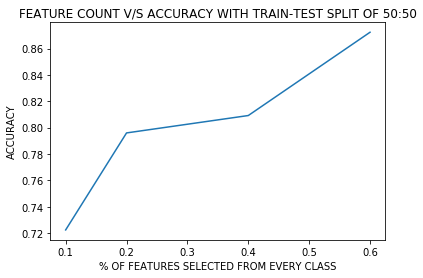

In [50]:
plt.plot(features[0:4],perf[0:4])
plt.xlabel("% OF FEATURES SELECTED FROM EVERY CLASS")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 50:50")
plt.show()

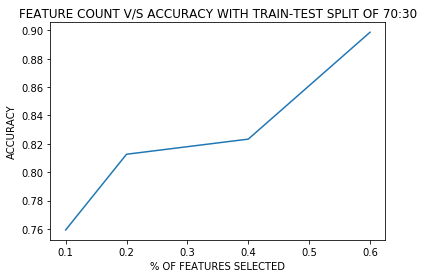

In [51]:
plt.plot(features[4:8],perf[4:8])
plt.xlabel("% OF FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 70:30")
plt.show()

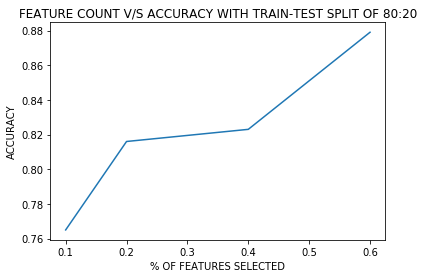

In [52]:
plt.plot(features[8:12],perf[8:12])
plt.xlabel("% OF FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 80:20")
plt.show()

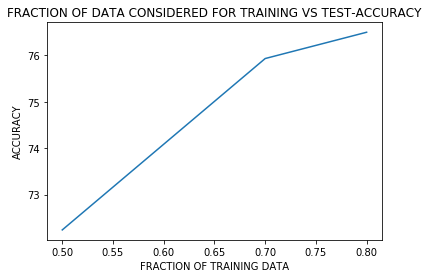

In [54]:
plt.plot([train_size[0],train_size[4],train_size[8]],[perf[0]*100,perf[4]*100,perf[8]*100])
plt.xlabel("FRACTION OF TRAINING DATA")
plt.ylabel("ACCURACY")
plt.title("FRACTION OF DATA CONSIDERED FOR TRAINING VS TEST-ACCURACY")
plt.show()